Student Number: C22056054

Name: Kushagra Raina

Course: MSc Artificial Intelligence

Subject: CMT400 Dissertation

School of Computer Science & Informatics,
Cardiff University


A dissertation submitted in partial fulfilment of CMT400 Dissertation for the
Requirements of MSc. Artificial Intelligence by taught programme, supervised by Dr. Matina Trachana


Please note, for running this code there's 2 modes,
1. Original data: Run class data + data analysis + the model of choice restart kernel for using a different model
2. Decomposed Data: Run Ensemble data + the model of choice

In [ ]:
# Option to connect the code to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install -q darts pytorch-forecasting transformers datasets evaluate accelerate "gluonts[torch]" ujson tqdm neuralforecast statsforecast utilsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 814.3/814.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 

##Class Data



In [ ]:
## This is a class for our FTSE100 dataset
import math
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import date
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests

In [ ]:
global START_DATE
START_DATE='2010-01-01'

In [ ]:
# ADF test
def adf_test(timeseries):

    dftest = adfuller(timeseries, autolag='AIC')
    adfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    print (adfoutput)
    return adfoutput

# KPSS test
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    return kpss_output

# API to get index data
def get_index_data(index_ticker='^FTSE'):

  df = yf.download(index_ticker,
  start=START_DATE,
  end=date.today(),
  progress=False)
  df.Close = df.Close.apply(lambda x: math.floor(x))
  return df

In [ ]:
# Class defined as index
class index():

  def __init__(self, index='^FTSE'):

      self.df = get_index_data(index)
      self.cols = self.df.columns
  # First 10 entries
  def print_self(self):
      print(self.df.head())


  ## Graph from start time and end time
  # def graph(time_start, time_end, column='Close'):

  # Test to check stationarity of time series
  # ADF --> Augmented Dickey-Fuller test
  # KPSS --> Kwiatkowski-Phillips-Schmidt-Shin test
  def check_stationary(self, test='ADF', pval=.01, column='Close', time_start=START_DATE, time_end=date.today()):
    if test=='ADF':
      out = adf_test(self.df[column])

    elif test=='KPSS':
      out = kpss_test(self.df[column])

    else:
      print('Test not found\nPlease select between ADF and KPSS tests')
      return

    if out['p-value']>pval:
      print('p-value higher than threshold, Time Series is not stationary')
    else:
      print('Time Series is stationary')
    return

# test to check granger causality
  def grangerCausalityTest(self, maxlag=30, verbose=False):
    return grangercausalitytests(self.df[['Close', 'Volume']], maxlag=maxlag, verbose=verbose)

  def clean_zeros(self):
    self.df=self.df[self.df['Volume']!=0]


# Data Analysis

In [ ]:
# Initializing class
# For training original data, keep choice None, otherwise, to train ensemble, use 'trend', 'stationary' or 'residual'
choice = None
ftse = index('^FTSE')
ftse.print_self()

                   Open         High          Low  Close    Adj Close  \
Date                                                                    
2010-01-04  5412.899902  5500.299805  5410.799805   5500  5500.299805   
2010-01-05  5500.299805  5536.399902  5480.700195   5522  5522.500000   
2010-01-06  5522.500000  5536.500000  5497.700195   5530  5530.000000   
2010-01-07  5530.000000  5551.700195  5499.799805   5526  5526.700195   
2010-01-08  5526.700195  5549.299805  5494.799805   5534  5534.200195   

                Volume  
Date                    
2010-01-04   750942000  
2010-01-05  1149301200  
2010-01-06   998295300  
2010-01-07  1162933700  
2010-01-08  1006420600  


In [ ]:
#Checking stationarity and granger causality
ftse.check_stationary(pval=0.1)
ftse.grangerCausalityTest()

Test Statistic                   -2.565994
p-value                           0.100231
#Lags Used                        8.000000
Number of Observations Used    3505.000000
Critical Value (1%)              -3.432217
Critical Value (5%)              -2.862365
Critical Value (10%)             -2.567209
dtype: float64
p-value higher than threshold, Time Series is not stationary


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (0.03076649576426539, 0.8607724663942555, 3510.0, 1),
   'ssr_chi2test': (0.030792791914491257, 0.8607034662713737, 1),
   'lrtest': (0.030792656958510634, 0.8607037683997997, 1),
   'params_ftest': (0.0307664957626384, 0.8607724663977463, 3510.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.7931012760073037, 0.06136724170895606, 3507.0, 2),
   'ssr_chi2test': (5.594166912653351, 0.060987676712360966, 2),
   'lrtest': (5.589716241978749, 0.06112354586563287, 2),
   'params_ftest': (2.7931012916691893, 0.06136724074936384, 3507.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.4997460478905342, 0.057756801037754955, 3504.0, 3),
   'ssr_chi2test': (7.5142194984106725, 0.057194215685271874, 3),
   'lrtest': (7.5061900108121336, 0.057399617252824386, 3),
   'params_ftest': (2.4997460421003432, 0.057756801484680036, 3504.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
 

In [ ]:
data = ftse.df.reset_index()
df_len = data.shape[0]

In [ ]:
from datetime import date


# Fills empty dates
def fill_empty_dates(df):

  dates = pd.date_range(df.Date.loc[0], date.today())

  i=0
  j=-1
  for d in dates:
    if d != df.Date.loc[i]:
      df.loc[j] = df.loc[i-1]
      df.at[j, 'Date'] = d
      j-=1
      i-=1

    i+=1

    if i==df_len:
      break
  df.index = df.index - j
  df = df.sort_values(by='Date')
  df = df.reset_index()

  return df

data = fill_empty_dates(data)

In [ ]:
#Generates granger causation matrix
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    maxlag=25
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


In [ ]:
gc_matrix=grangers_causation_matrix(data, variables=data.columns[2:])
gc_matrix

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print resul

,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x
Open_y,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
High_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
Low_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0026
Close_y,0.0005,0.0303,0.0004,1.0000,0.0384,0.2711
Adj Close_y,0.0005,0.0289,0.0004,0.0398,1.0000,0.2711
Volume_y,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000



# STL Decomposition




In [ ]:
from statsmodels.tsa.seasonal import STL, STL

In [ ]:
train = data[data.Date<'2023-01-01']
test = data[data.Date>='2023-01-01']

In [ ]:
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [ ]:
stl_kwargs = {"seasonal_deg": 0}
model_train = STL(train['Close'], period=7)
comp_train = model_train.fit()

model_test = STL(test['Close'], period=7)
comp_test = model_test.fit()

In [ ]:
dic_train = {'trend': comp_train.trend.values, 'seasonal': comp_train.seasonal.values, 'residual': comp_train.resid.values}
dic_test = {'trend': comp_test.trend.values, 'seasonal': comp_test.seasonal.values, 'residual': comp_test.resid.values}

comp_train_df = pd.DataFrame(data=dic_train, index=train.Date)
comp_test_df = pd.DataFrame(data=dic_test, index=test.Date)

In [ ]:
comp_train_df.head()

,trend,seasonal,residual
Date,,,
2010-01-04,5522.193420,-7.383037,-14.810384
2010-01-05,5521.591420,-6.772182,7.180763
2010-01-06,5520.884108,-16.184956,25.300848
2010-01-07,5520.080004,-3.025332,8.945328
2010-01-08,5519.136146,-5.681253,20.545107


In [ ]:
comp_train_df.to_csv('/content/decomposed_train.csv')
comp_test_df.to_csv('/content/decomposed_test.csv')

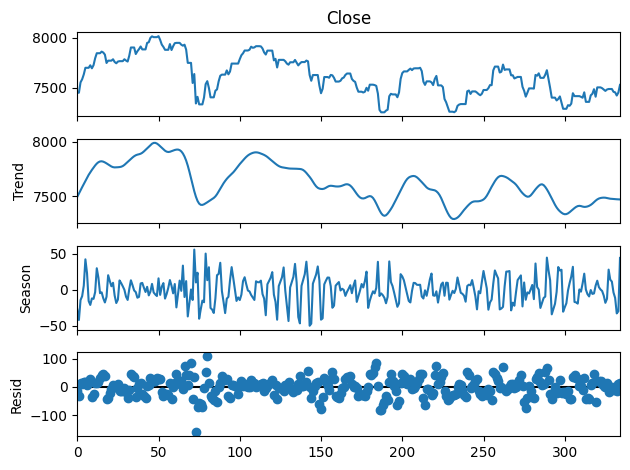

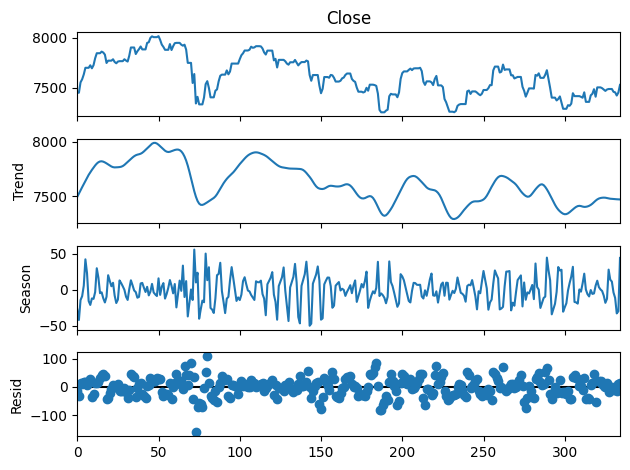

In [ ]:
comp_test.plot()

#Ensemble Data

In [ ]:
# Kindly please upload the decomposed data from the supporting documents
# Please Only run this section if you'd like to train the models on decomposed parts of the closing price of our index.
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/decomposed_data.csv')

In [ ]:
def normalize_list(numbers):
    """
    Normalize a list of numbers between 0 and 1.

    Parameters:
    - numbers (list): List of numbers to be normalized.

    Returns:
    - list: Normalized list of numbers.
    """
    min_val = min(numbers)
    max_val = max(numbers)
    normalized_numbers = [(x - min_val) / (max_val - min_val) for x in numbers]
    return normalized_numbers, min_val, max_val

In [ ]:
def reconvert_list(normalized_numbers, original_min, original_max):
    """
    Reconvert a normalized list of numbers back to the original scale.

    Parameters:
    - normalized_numbers (list): Normalized list of numbers.
    - original_min (float): Minimum value of the original scale.
    - original_max (float): Maximum value of the original scale.

    Returns:
    - list: Reconverted list of numbers.
    """
    reconverted_numbers = [x * (original_max - original_min) + original_min for x in normalized_numbers]
    return reconverted_numbers

In [ ]:
def get_ensemble_data(data, col='trend'):
  if col=='trend':
    data = data[['Date', 'trend']]
    data = data.rename(columns={'trend': 'Close'})
    data['Date'] = pd.to_datetime(data['Date'])
    return data
  elif col =='seasonal':
    data = data[['Date', 'seasonal']]
    data = data.rename(columns={'seasonal': 'Close'})

    norm_seas, min_seas, max_seas = normalize_list(data.Close)
    data.Close=norm_seas
    data['Date'] = pd.to_datetime(data['Date'])
  elif col == 'residual':
    data = data[['Date', 'residual']]
    data = data.rename(columns={'residual': 'Close'})

    norm_res, min_res, max_res = normalize_list(data.Close)
    data.Close=norm_res
    data['Date'] = pd.to_datetime(data['Date'])
  else :
    print('Please pick one of trend, seasonality or residuals')

In [ ]:
 # Choice between trend, seasonality, residuals, otherwise it's none
choice = None #'trend'
get_ensemble_data(data, choice)

Please pick one of trend, seasonality or residuals


# Statsforecast For classical models


In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoCES, AutoETS, AutoTheta, AutoRegressive

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
train

,Unnamed: 0,ds,trend,seasonal,residual,unique_id
0,0,2010-01-04,5522.494045,-7.426549,-14.767691,ftse
1,1,2010-01-05,5521.893620,-6.530881,7.137261,ftse
2,2,2010-01-06,5521.187902,-16.171999,24.984096,ftse
3,3,2010-01-07,5520.385380,-2.834843,9.149658,ftse
4,4,2010-01-08,5519.443714,-5.797866,20.554348,ftse
...,...,...,...,...,...,...
4983,238,2023-08-27,7373.502795,-8.124359,-26.778338,ftse
4984,239,2023-08-28,7391.178816,-16.196748,-36.381970,ftse
4985,240,2023-08-29,7407.392027,5.381738,52.226235,ftse
4986,241,2023-08-30,7422.715569,7.134416,43.850210,ftse


In [ ]:
data = data.assign(unique_id=['ftse' for i in range(len(data))])
if choice is not None:
  data = data.rename(columns={choice: 'y', 'Date': 'ds'})
else:
  data = data.rename(columns={'Close': 'y', 'Date': 'ds'})

forecast_period = 60
cutoff_date='2023-09-01'
train = data[data.ds<cutoff_date]
test = data[data.ds>cutoff_date]
train = train[['ds','y','unique_id']]
test = test[['ds','y','unique_id']]

In [ ]:
models = StatsForecast(
    models = [AutoARIMA(), AutoETS(), AutoCES(), AutoTheta()],
    freq = 'D'
)
models.fit(train)

StatsForecast(models=[AutoARIMA,AutoETS,CES,AutoTheta])

In [ ]:
pred = models.predict(h=forecast_period, level=[95])

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape
for col in pred.columns:
  if col in ['AutoARIMA', 'AutoETS', 'CES', 'AutoTheta', 'AutoRegressive']:
    print('{} mape: {}'.format(col, 100*mape(pred[col].values[:forecast_period],test.y.values[:forecast_period] )))

AutoARIMA mape: 1.6646502666128962
AutoETS mape: 1.6615170197384317
CES mape: 1.6180700594722066
AutoTheta mape: 1.6426034889536478


# NBeats

In [ ]:
# Setting data to test starting 1st January 2023
data = data[data.Date<'2023-03-02']
data

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,1567,2010-01-04,5412.899902,5500.299805,5410.799805,5500,5500.299805,750942000
1,1568,2010-01-05,5500.299805,5536.399902,5480.700195,5522,5522.500000,1149301200
2,1569,2010-01-06,5522.500000,5536.500000,5497.700195,5530,5530.000000,998295300
3,1570,2010-01-07,5530.000000,5551.700195,5499.799805,5526,5526.700195,1162933700
4,1571,2010-01-08,5526.700195,5549.299805,5494.799805,5534,5534.200195,1006420600
...,...,...,...,...,...,...,...,...
4800,86,2023-02-25,7907.700195,7939.200195,7870.399902,7878,7878.700195,879172000
4801,85,2023-02-26,7907.700195,7939.200195,7870.399902,7878,7878.700195,879172000
4802,4887,2023-02-27,7878.700195,7950.000000,7878.700195,7935,7935.100098,755879000
4803,4888,2023-02-28,7935.100098,7935.100098,7854.799805,7876,7876.299805,1246757900


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.tsdataset import TimeSeriesDataset

In [ ]:
# divides data into train and test sets
def get_data(data, input_steps, prediction_horizon, val_steps):
  df = data.assign(unique_id=['ftse' for i in range(len(data))])
  df = df.rename(columns={'Close': 'y', 'Date': 'ds'})


  train = df[:][:-(prediction_horizon+input_steps)]
  test = df[:][-(input_steps + prediction_horizon):-prediction_horizon]
  predictions = df[:][-prediction_horizon:]

  train = train[['ds','y','unique_id']]
  test = test[['ds','y','unique_id']]
  return train, test, predictions

In [ ]:
# Defines model
def get_model(input_steps, random_seed,  prediction_horizon=10, val_steps=10, epochs=300, early_stop=10):
  model = NBEATS(h=prediction_horizon, input_size=input_steps,
                loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
                stack_types = ['identity', 'trend', 'seasonality'],
                max_steps=epochs,
                val_check_steps=val_steps,
                early_stop_patience_steps=early_stop,
                random_seed=random_seed)
  fcst = NeuralForecast(
      models=[model],
      freq='D'
  )
  return fcst

In [ ]:
from random import seed, randint

# Training multiple times having different random seed i

for i in range(6):

  seed(i)
  ## Feel free to change the parameters below to see how it works..
  input_steps = 60
  prediction_horizon = 60
  val_steps = 60
  num_epochs=1 #300 default
  train, test, preds = get_data(data, input_steps=input_steps, prediction_horizon=prediction_horizon, val_steps=val_steps)
  nbeats = get_model(input_steps=input_steps, prediction_horizon=prediction_horizon, val_steps=val_steps, epochs=num_epochs, random_seed=randint(0, 100))
  nbeats.fit(df=train, val_size=val_steps)
  nbeats_forecasts = nbeats.predict(test)
  plot_df = pd.merge(preds[['ds', 'y']], nbeats_forecasts, how='inner', on='ds')
  print('{}th iteration mape: {}'.format(i+1, mape(plot_df.y.values, plot_df.NBEATS.values)))
  break


INFO:lightning_fabric.utilities.seed:Seed set to 49


KeyboardInterrupt: ignored

In [ ]:
prints = False
if prints:
  print(nbeats_forecasts.ds)
  for l in nbeats_forecasts.NBEATS:
    print(l)

if choice in ['seasonality', 'residuals'] and prints:
  for l in reconvert_list(nbeats_forecasts.NBEATS, min_res, max_res):
    print(l)

# NHits


In [ ]:
# Setting data to test starting 1st January 2023
data = data[data.Date<'2023-03-02']
data

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,1567,2010-01-04,5412.899902,5500.299805,5410.799805,5500,5500.299805,750942000
1,1568,2010-01-05,5500.299805,5536.399902,5480.700195,5522,5522.500000,1149301200
2,1569,2010-01-06,5522.500000,5536.500000,5497.700195,5530,5530.000000,998295300
3,1570,2010-01-07,5530.000000,5551.700195,5499.799805,5526,5526.700195,1162933700
4,1571,2010-01-08,5526.700195,5549.299805,5494.799805,5534,5534.200195,1006420600
...,...,...,...,...,...,...,...,...
4800,86,2023-02-25,7907.700195,7939.200195,7870.399902,7878,7878.700195,879172000
4801,85,2023-02-26,7907.700195,7939.200195,7870.399902,7878,7878.700195,879172000
4802,4887,2023-02-27,7878.700195,7950.000000,7878.700195,7935,7935.100098,755879000
4803,4888,2023-02-28,7935.100098,7935.100098,7854.799805,7876,7876.299805,1246757900


In [ ]:
# Importing libraries
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import DistributionLoss, HuberLoss, MAE
from neuralforecast.tsdataset import TimeSeriesDataset

In [ ]:
## Getting data

def get_data(data, input_steps, prediction_horizon, val_steps):

  df = data.rename(columns={'Close': 'y', 'Date': 'ds'})
  df = df.assign(unique_id=['FTSE' for i in range(len(df))])

  train = df[:][:-(prediction_horizon+input_steps)]
  test = df[:][-(input_steps + prediction_horizon):-prediction_horizon]
  predictions = df[:][-prediction_horizon:]

  train = train[['ds','y','unique_id']]
  test = test[['ds','y','unique_id']]
  return train, test, predictions

In [ ]:
## Getting Model

def get_model(input_steps, random_seed, lr=1e-3, prediction_horizon=10,val_steps=10, epochs=300, early_stop=10):

  model = NHITS(h=prediction_horizon,
                input_size=input_steps,
                #loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
                loss=HuberLoss(delta=0.5),
                valid_loss=MAE(),
                # stat_exog_list=['ftse'],
                scaler_type='robust',
                max_steps=epochs,
                early_stop_patience_steps=early_stop,
                val_check_steps=val_steps,
                learning_rate=lr,
                random_seed=random_seed)

  fcst = NeuralForecast(models=[model], freq='D')
  return fcst

In [ ]:
from random import seed, randint
from sklearn.metrics import mean_absolute_percentage_error as mape


## Iterating with different random seed for tests
for i in range(6):

  seed(i)
  input_steps = 60
  prediction_horizon = 30
  val_steps = 30
  num_epochs=1 # 300 default
  train, test, preds = get_data(data, input_steps=input_steps,prediction_horizon=prediction_horizon, val_steps=val_steps)
  nhits = get_model(input_steps=input_steps, prediction_horizon=prediction_horizon, val_steps=val_steps, epochs=num_epochs, random_seed=randint(0, 100))
  nhits.fit(df=train, val_size=val_steps) ##static_df=AirPassengersStatic
  nhits_forecasts = nhits.predict(test)
  plot_df = pd.merge(preds[['ds', 'y']], nhits_forecasts, how='inner', on='ds')
  print('With input size:{} /n mape: {}'.format(input_steps, mape(plot_df.y.values, plot_df.NHITS.values)))
  break

INFO:lightning_fabric.utilities.seed:Seed set to 49


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

With input size:60 /n mape: 0.016339012897127574


In [ ]:
prints=False
if prints:
  for l in nhits_forecasts.NHITS:
    print(l)

if choice in ['seasonality', 'residuals'] and prints:
  for l in reconvert_list(nhits_forecasts.NHITS, min_res, max_res):
    print(l)

#Temporal Fusion Transformer

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from tqdm import tqdm_notebook as tqdm
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from datetime import datetime, date

import torch
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [ ]:
# Below parameter changes the type of training occurring, options being uni(univariate), vol_only(CV data), all(OCHLV data)
multi='uni'
if multi=='all':
  vars = ['Open', 'High', 'Low', 'Close', 'Volume']
elif multi=='vol_only':
  vars = ['Close', 'Volume']
else:
  vars = ['Close']
series = TimeSeries.from_dataframe(data, 'Date', vars, freq='D')
series = series.astype(np.float32)


# Create training and validation sets: ** this date decides when we test for
training_cutoff = pd.Timestamp("20221231")
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(datetime_attribute_timeseries(series, attribute="month", one_hot=False))
covariates = covariates.stack(datetime_attribute_timeseries(series, attribute="day", one_hot=False))
covariates = covariates.stack(datetime_attribute_timeseries(series, attribute="dayofweek", one_hot=False))
covariates = covariates.stack(datetime_attribute_timeseries(series, attribute="week", one_hot=False))
covariates = covariates.stack(datetime_attribute_timeseries(series, attribute="weekday", one_hot=False))
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [ ]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
num_samples=1
input_chunk_length = 60
forecast_horizon = 60
hidden_size = 128
lstm_layers = 4
attention_heads = 4
epochs = 1

In [ ]:
#Configuring model
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hidden_size,
    lstm_layers=lstm_layers,
    num_attention_heads=attention_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=epochs,
    add_relative_index=False,
    add_encoders=None,
    likelihood=None,
    # QuantileRegression(quantiles=quantiles),
    loss_fn=torch.nn.MSELoss(),
    random_state=1,
    optimizer_kwargs={'lr':1e-4}
    )

In [ ]:
#training module
def train_model(my_model, fileName, flag=False):

  if flag:
    my_model = TFTModel.load(fileName)
  my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)
  my_model.save(fileName)
  return my_model

In [ ]:
filename='/content/drive/MyDrive/TSF/Checkpoints/TFT/model_{}_{}_{}_{}_{}_{}_{}.pt'.format(input_chunk_length, forecast_horizon, hidden_size, lstm_layers, attention_heads, epochs, multi)
my_model = train_model(my_model, filename)

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Evaluating model
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)
    print(pred_series.start_time(), pred_series.end_time())
    lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
    label_q_outer= f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
    label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"    # plot actual series
    plt.figure(figsize=(10,7))
    actual_series[pred_series.start_time(): pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    # plt.title("MAPE: {:.2f}%".format(mape(val_series[:forecast_horizon], pred_series)))
    plt.legend()

    return pred_series, actual_series, val_series

Predicting: |          | 0/? [00:00<?, ?it/s]

2023-01-01 00:00:00 2023-03-01 00:00:00


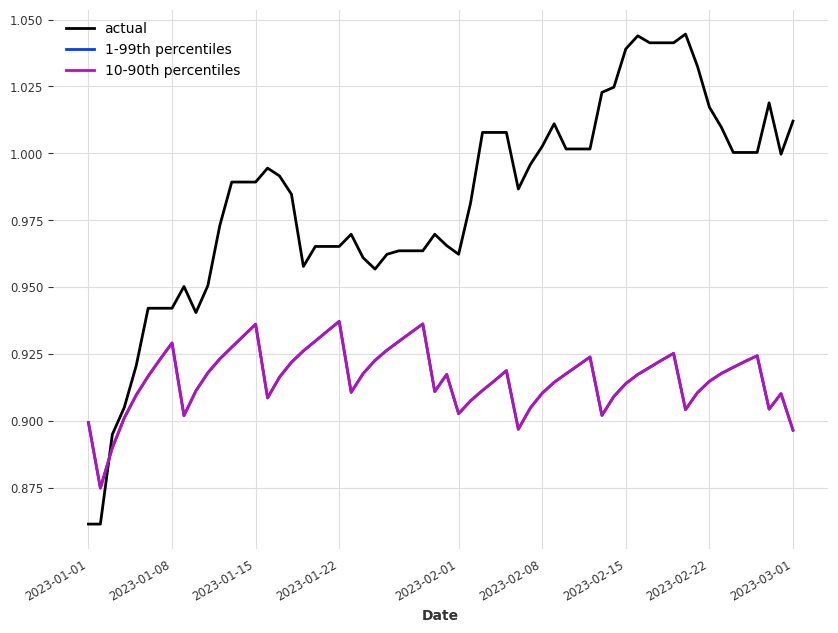

In [ ]:
pred, act, val = eval_model(my_model, forecast_horizon, series_transformed, val_transformed)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape
## testing MAPE score
def results_df(pred, val):
  results = {}

  for i, var in enumerate(vars):
    results['Predictions_{}'.format(var)] = np.transpose(pred)[i]
    results['Actuals_{}'.format(var)] = np.transpose(val[:forecast_horizon])[i]
    if var == 'Close':
      print('MAPE {}'.format(mape(np.transpose(pred[:forecast_horizon])[i], np.transpose(val[:forecast_horizon])[i])))
  index = data.loc[data.Date>='2023-01-01'][:forecast_horizon].Date
  new_df = pd.DataFrame(results, index=index)
  new_df.to_csv('/content/drive/MyDrive/TSF/Checkpoints/TFT/results_{}_{}_{}_{}_{}_{}_{}.csv'.format(input_chunk_length, forecast_horizon, hidden_size, lstm_layers, attention_heads, epochs, multi))
  return new_df

In [ ]:
res = results_df(transformer.inverse_transform(pred).values(), transformer.inverse_transform(val_transformed).values()[:forecast_horizon])

MAPE 0.02732505090534687


In [ ]:
prints = False
if prints :
  for l in res.Predictions_Close.values:
    print(l)
if choice in ['seasonality', 'residuals'] and prints:
  for l in reconvert_list(res.Predictions_Close.values, min_seas, max_seas):
    print(l)

# Autoformer

In [ ]:
import json
import datasets
import pyarrow as pa
import pyarrow.dataset as ds

from datasets import Dataset
from datasets import load_dataset
from datetime import datetime

In [ ]:
# transforming to huggingface dataset
def make_dataset(data, vars, prediction_length=10, cutoff_date='2023-01-01',flag='train',columns=['Close', 'Volume']):

  if flag=='train':
    data = data.loc[data.Date<cutoff_date]
  elif flag=='test':
    data = data.loc[data.Date>=cutoff_date]
  freq = "D"
  df = pd.DataFrame(columns=['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])
  for i, col in enumerate(vars):

    df.at[i, 'start'] =  data.Date.iloc[0].to_pydatetime().isoformat()
    df.at[i, 'target'] =  data[col].values
    df.at[i,'feat_static_cat'] = [0]
    df.at[i, 'feat_dynamic_real'] = None
    df.at[i, 'item_id'] = col
  return df

In [ ]:
# Below parameter changes the type of training occurring, options being uni(univariate), vol_only(CV data), all(OCHLV data)
multi='all'
if multi=='all':
  vars = ['Open', 'High', 'Low', 'Close', 'Volume']
elif multi=='vol_only':
  vars = ['Close', 'Volume']
else:
  vars = ['Close']

freq = "D"
prediction_length = 60
df_train = make_dataset(data, vars, flag='train', prediction_length=prediction_length, columns=data.columns)
df_train.reset_index(drop=True, inplace=True)

df_test = make_dataset(data, vars, prediction_length=prediction_length, flag='test', columns=data.columns)
df_test.reset_index(drop=True, inplace=True)


train_dataset = Dataset.from_pandas(df_train)
test_dataset =  Dataset.from_pandas(df_test)

In [ ]:
#some hyperparameters
context_length = 60
batch_size = 128
num_batches_per_epoch = 100
scaling = "std"
encoder_layers=2
decoder_layers=2
d_model=16

In [ ]:
from functools import lru_cache

import pandas as pd
import numpy as np



def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [ ]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper

num_of_variates = len(train_dataset)

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates,
    num_test_dates=len(test_dataset) // num_of_variates, # number of rolling test windows
)

multi_variate_train_dataset = train_grouper(train_dataset)
multi_variate_test_dataset = test_grouper(test_dataset)

In [ ]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31, 56, 84, 363, 364, 365, 727, 728, 729, 1091, 1092, 1093]


In [ ]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function day_of_week at 0x7fcd48fceb00>, <function day_of_month at 0x7fcd48fcec20>, <function day_of_year at 0x7fcd48fced40>]


In [ ]:
from transformers import PretrainedConfig
from gluonts.time_feature import time_features_from_frequency_str

from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create a list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [ ]:
from gluonts.transform import InstanceSplitter
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [ ]:
from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream, is_train=True)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [ ]:
from transformers import AutoformerConfig, AutoformerForPrediction

config = AutoformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,

    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
)

model = AutoformerForPrediction(config)

In [ ]:
# model.config

In [ ]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=32,
)


In [ ]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 127, 4]) torch.FloatTensor
past_values torch.Size([256, 127, 5]) torch.FloatTensor
past_observed_mask torch.Size([256, 127, 5]) torch.FloatTensor
future_time_features torch.Size([256, 60, 4]) torch.FloatTensor
future_values torch.Size([256, 60, 5]) torch.FloatTensor
future_observed_mask torch.Size([256, 60, 5]) torch.FloatTensor


In [ ]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

print("Loss:", outputs.loss.item())

Loss: 62.60538101196289


In [ ]:
from accelerate import Accelerator
from torch.optim import AdamW

epochs = 1
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    print('Epoch ', epoch)
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 100 == 0:
            print(loss.item())

Epoch  0
62.648502349853516


In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
device = accelerator.device
model.to(device)
model.eval()

forecasts_ = []
for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())


In [ ]:
forecasts = np.vstack(forecasts_)

In [ ]:
from tqdm.autonotebook import tqdm
from evaluate import load
from gluonts.time_feature import get_seasonality
from sklearn.metrics import mean_absolute_percentage_error as mape

mase_metric = load("evaluate-metric/mase")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
for item_id, ts in enumerate(tqdm(test_dataset)):

    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    if ts["item_id"]=='Close':
      print(mape(forecast_median[0].T[item_id], np.array(ground_truth)))
      results = pd.DataFrame(columns=['predictions', 'actuals'],index=None)
      results['predictions'], results['actuals'] = forecast_median[0].T[item_id], np.array(ground_truth)
      # results.to_csv('/content/drive/MyDrive/TSF/Checkpoints/TFT/results_autoformer.csv')


  0%|          | 0/5 [00:00<?, ?it/s]

0.046547987913602484


In [ ]:
prints=False
if prints:
  for pred in results.predictions:
    print(pred)
if choice in ['seasonality', 'residuals'] and prints:
  for l in reconvert_list(results.Predictions_Close.values, min_seas, max_seas):
    print(l)

# Results


In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error as mape

df = pd.read_excel('/content/drive/MyDrive/Decomp_results.xlsx')

In [ ]:
df.columns

Index(['Date', 'Trend', 'Nbeats', 'Nhits', 'Autoformer', 'TFT ', 'Seasonality',
       'Nbeats.1', 'Nhits.1', 'Autoformer.1', 'TFT', 'residuals', 'Nbeats.2',
       'Nhits.2', 'Autoformer.2', 'TFT.1', 'Prediction', 'Actual'],
      dtype='object')

In [ ]:
def normalize_list(numbers, min_val=None, max_val=None):
    """
    Normalize a list of numbers between 0 and 1.

    Parameters:
    - numbers (list): List of numbers to be normalized.

    Returns:
    - list: Normalized list of numbers.
    """
    if min_val is None or max_val is None:
      min_val = min(numbers)
      max_val = max(numbers)
    normalized_numbers = [(x - min_val) / (max_val - min_val) for x in numbers]
    return normalized_numbers, min_val, max_val

In [ ]:
cols = ['Trend', 'Seasonality', 'residuals', 'Prediction']
series=None
tag=None
for col in df.columns:
  if col in cols:
    series = df[col]
    tag=col
    continue

  if series is not None:
    if col == 'Seasonality' or col == 'residuals':
      act, mi, ma = normalize_list(series.values)
      pred, _, _ = normalize_list(df[col].values, mi, ma)
      print('{} model {} MAPE: {}'.format(col, tag, mape(act, pred)))
    else:
      act = series.values
      pred = df[col].values
      print('{} model {} MAPE: {}'.format(col, tag, mape(act, pred)))


Nbeats model Trend MAPE: 0.033975783641451734
Nhits model Trend MAPE: 0.025669896098950467
Autoformer model Trend MAPE: 0.015190687525304806
TFT  model Trend MAPE: 0.02191239528916515
Nbeats.1 model Seasonality MAPE: 2.261294017040192
Nhits.1 model Seasonality MAPE: 3.2897749187638903
Autoformer.1 model Seasonality MAPE: 2.3799102416746525
TFT model Seasonality MAPE: 3.2125970769349124
Nbeats.2 model residuals MAPE: 2.2091917708516027
Nhits.2 model residuals MAPE: 2.823395742237131
Autoformer.2 model residuals MAPE: 1.1171722771682961
TFT.1 model residuals MAPE: 1.1325336098948873
Actual model Prediction MAPE: 0.023821456314522767


In [ ]:
final_results = pd.read_excel('/content/drive/MyDrive/model_results.xlsx')
final_results.head()

,Date,Actual,Autoformer,Autoformer CV,Autoformer OCHLV,Nbeats,NHits,TFT uni,TFT CV,TFT OCHLV
0,2023-01-01,7451.700195,7448.624023,7440.569824,7280.909668,7437.640137,7449.172852,7600.7827,7354.2700,7489.3423
1,2023-01-02,7451.700195,7494.065430,7456.822266,7378.414062,7441.916992,7450.725586,7638.2100,7419.1772,7433.7393
2,2023-01-03,7554.100098,7571.621582,7413.010742,7333.875000,7441.816895,7451.641113,7634.6570,7408.4517,7422.2610
3,2023-01-04,7585.200195,7618.907227,7465.578125,7323.916016,7433.854980,7467.995117,7629.7573,7404.7515,7413.2417
4,2023-01-05,7633.500000,7688.074219,7485.353027,7373.676270,7448.829102,7470.486816,7623.9700,7403.2236,7404.6860


In [ ]:

forecast=30
for col in final_results.columns[2:]:

  act = final_results.Actual.values[:forecast]
  pred = final_results[col].values[:forecast]
  assert len(act) == len(pred)
  print('{} Mape: {}'.format(col, mape(final_results.Actual.values[:forecast], final_results[col].values[:forecast])))

Autoformer Mape: 0.011362204190805728
Autoformer CV Mape: 0.040142506698026784
Autoformer OCHLV Mape: 0.050441246127580205
Nbeats Mape: 0.03710408652262924
NHits  Mape: 0.03183554013113798
TFT uni Mape: 0.017989719787041135
TFT CV  Mape: 0.04215568833101449
TFT OCHLV  Mape: 0.04578746962377536


In [ ]:
temp_df = final_results[:30]
temp_df = temp_df.merge(df[['Date','Prediction']], how='inner', on='Date')
temp_df=temp_df.rename(columns={'TFT uni': "Temporal Fusion Transformer"}, errors="raise")
temp_df.columns

Index(['Date', 'Actual', 'Autoformer', 'Autoformer CV', 'Autoformer OCHLV',
       'Nbeats', 'NHits ', 'Temporal Fusion Transformer', 'TFT CV ',
       'TFT OCHLV ', 'Prediction'],
      dtype='object')

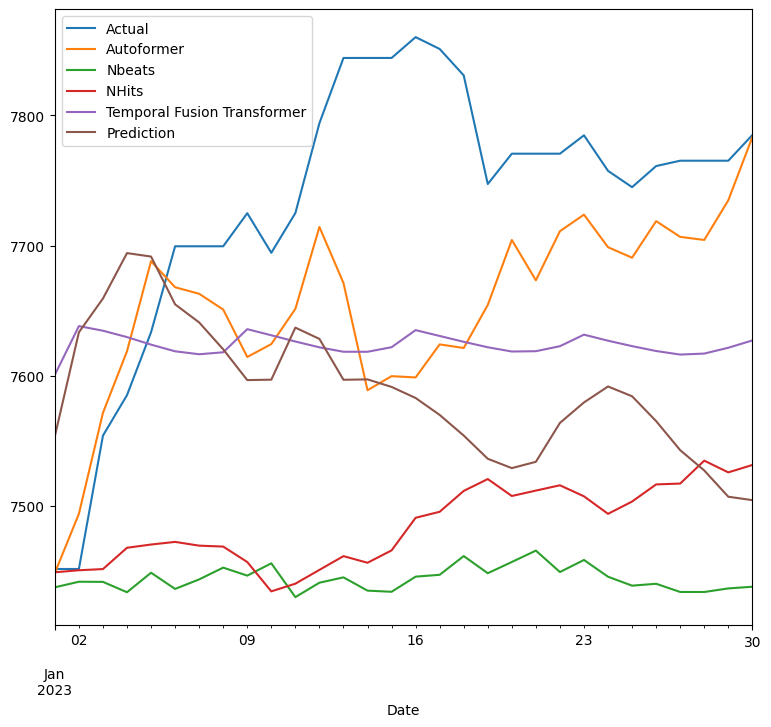

In [ ]:
# plot the dataframe
temp_df.plot(x="Date", y=['Actual', 'Autoformer', 'Nbeats', 'NHits ', 'Temporal Fusion Transformer', 'Prediction'], figsize=(9, 8))

# print bar graph
plt.show()

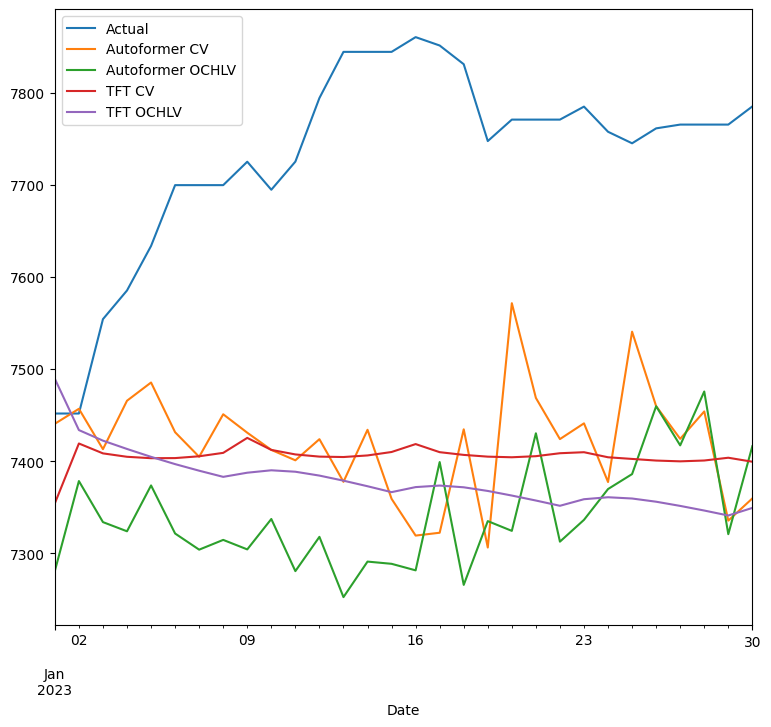

In [ ]:
# plot the dataframe
temp_df.plot(x="Date", y=['Actual', 'Autoformer CV', 'Autoformer OCHLV', 'TFT CV ', 'TFT OCHLV '], figsize=(9, 8))

# print bar graph
plt.show()